
import numpy as np
import pandas
import matplotlib as plt

#print ("Hi all")
#weekMax = 51
#NShops = 80
#lastNWeeksDown = 6

def changeConfig(sWeek, sItem, sStore):

    configfilename = "params.txt"
    fconfig = open(configfilename, "r")
    linesList = []
    for l in fconfig:
        toNewConf  = l
        if l.split()[0] == 'sWeek':
            toNewConf = 'sWeek = ' + str(sWeek) + "\n"

        if l.split()[0] == 'sItem':
            toNewConf = 'sItem = ' + str(sItem) + "\n"

        if l.split()[0] == 'sStore':
            toNewConf = 'sStore = ' + str(sStore) + "\n"
        linesList.append(toNewConf)


    fconfig.close()
    fconfig = open(configfilename, "w")
    for line in linesList:
        fconfig.write(line)



def generateSimpleData(delta, alpha, scale, season):

    priceMatrix = np.append(np.ones((NShops, weekMax - lastNWeeksDown)), (1 - delta)*np.ones((NShops,lastNWeeksDown)), 1)
    
    #lastMarkdownArray = (1 - delta/2)*np.ones((NShops,lastNWeeksDown/2))
    #lastMarkdownArray = np.append(lastMarkdownArray, (1 - delta)*np.ones((NShops,lastNWeeksDown/2)), 1)
    #priceMatrix = np.append(np.ones((NShops, weekMax - lastNWeeksDown)), lastMarkdownArray, 1)
    
    #priceMatrix = np.append(np.ones((NShops, weekMax - lastNWeeksDown)), np.random.uniform(1 - delta - 0.1,1 - delta + 0.1 ,(NShops,lastNWeeksDown)), 1)
    
    #effictivityScale = scale*np.arange(1, NShops+1)
    effictivityScale = scale*np.linspace(1, 10, NShops) 

    slsu = np.zeros((NShops, weekMax))
    for weekNo in range(weekMax):
        for ShopNo in range(NShops):
            slsu[ShopNo, weekNo] = np.random.poisson(effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha)))
            # slsu[ShopNo, weekNo] = effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha))

    return priceMatrix,  slsu


def DataToFile(slsu, price, onHand):
    fLogP = open("RawData/RawDataLogPrice.txt", "w")
    fSlsu = open("RawData/RawDataSLSU.txt", "w")
    fBoh = open("RawData/RawDataBOH.txt", "w")
    
    for shopNo in range(NShops):
        for t in range(weekMax):
            #print np.log(price[shopNo, t]), " "
            fLogP.write(str( -np.log(price[shopNo, t])) + " ")
            fSlsu.write(str(slsu[shopNo, t])+ " ")
            fBoh.write(str(onHand[shopNo, t])+ " ")

if __name__ == "__main__":

    #season = np.cos (np.linspace(0, 2*np.pi, weekMax)) + 2
    #season = np.linspace(1, 0, weekMax) + 2
    season = np.array([1]*weekMax)
    season = season/sum(season)

    price, slsu = generateSimpleData(delta = 0.2, alpha = 1.75, scale = 400, season = season)
    onHand = np.ones((NShops,weekMax) )*100
    #print price, slsu, onHand
    #DataToFile(slsu, price, onHand)
    #changeConfig(sWeek =weekMax , sItem = 1, sStore = NShops)

dics = np.random.randint(0, 12)

price,  slsu, on_hand, rew = generateSimpleData(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)

res_ser = rew*unit_price
days_left = np.arange(weekMax, 0, -1)  






state_cols = ['d_r_sh', 'days_left']

df = pd.concat([pd.Series(price), 
           pd.Series(season),
           pd.Series(on_hand),
           pd.Series(days_left), 
           pd.Series(slsu), 
           pd.Series(res_ser)], 1)

df.columns = ['price','season', 'on_hand','days_left', 'slsu' , 'rev_ser']
df['d_r_sh'] = df.on_hand / df.slsu


df['action'] = (df.price.shift(-1) - df.price ).fillna(0)

df_shifted = df[state_cols].shift(-1)
df_shifted.columns = [col + '_next' for col in df_shifted.columns]




pd.concat([df[state_cols], df_shifted, df[['action', 'rev_ser']]], 1)

In [1]:
%matplotlib inline

In [2]:
def generateSimpleData(delta, alpha, scale, season, init_oh, disc_len, weekMax):

    price = np.append(np.ones( weekMax - disc_len), (1 - delta)*np.ones(disc_len))
    
    slsu = np.zeros(weekMax)
    bst_est = np.zeros(weekMax)
    on_hand = np.zeros(weekMax)
    on_hand[0]=init_oh
    rew = np.zeros(weekMax)
    
    for weekNo in range(weekMax):
        if weekNo:
            on_hand[weekNo] = on_hand[weekNo-1] - slsu[weekNo-1]   
            
        curr_mean =scale*weekMax*season[weekNo]*(price[ weekNo]**(-alpha))
        demand = np.random.poisson(curr_mean)
        slsu[weekNo] = min(demand, on_hand[weekNo])
        rew[weekNo] = slsu[weekNo]*price[weekNo]
        bst_est[weekNo] = curr_mean
            # slsu[ShopNo, weekNo] = effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha))

    return price,  slsu, on_hand, rew, bst_est

In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd

In [4]:
weekMax = 12
init_oh = 800

season = np.array([1]*weekMax)
season = season/sum(season)

### Смотрим на награду в зависимости от глубины скидки

In [5]:
res_dict = {}
for dics in tqdm(np.linspace(.0,.7, 40 )):
    tmp_list = []
    for i in range(1000):
        price,  slsu, on_hand, rew, _ = generateSimpleData(delta = dics, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = 6, weekMax = weekMax)
        tmp_list.append(np.sum(rew[:]))
    res_dict[dics] = np.mean(tmp_list)


100%|██████████| 40/40 [00:11<00:00,  3.21it/s]


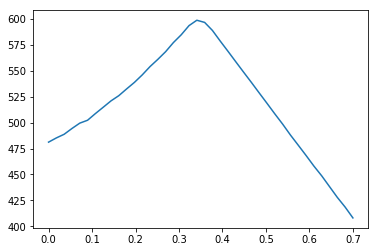

In [6]:
pd.Series(res_dict).plot()

### Смотрим на награду в зависимости от размера скидочного периода 

In [7]:
res_dict = {}
for dics in tqdm(range(12)):
    tmp_list = []
    for i in range(100):
        price,  slsu, on_hand, rew, _ = generateSimpleData(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics, weekMax = weekMax)
        tmp_list.append(np.sum(rew[:]))
    res_dict[dics] = np.mean(tmp_list)

100%|██████████| 12/12 [00:00<00:00, 26.32it/s]


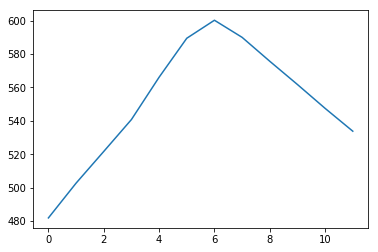

In [8]:
pd.Series(res_dict).plot()

### Точная оценка Q и V

In [9]:
state_cols = [ 'oh_after', 'days_left']
next_state_cols = [col + '_next' for col in state_cols]

def gen_rl_df(delta, alpha, scale, season, init_oh, disc_len, unit_price =1, weekMax = 12):
    dics = np.random.randint(0, weekMax+1)
    price,  slsu, on_hand, rew, best_est = generateSimpleData(delta, alpha, scale, \
                                                    season, init_oh, disc_len = dics, weekMax = weekMax)

    res_ser = rew*unit_price
    days_left = np.arange(weekMax, 0, -1)-1


    df = pd.concat([pd.Series(price), 
               pd.Series(season),
               pd.Series(on_hand),
               pd.Series(days_left), 
               pd.Series(slsu), 
               pd.Series(res_ser).shift(-1), 
               pd.Series(best_est)], 1)

    
    df.columns = ['price','season', 'on_hand','days_left', 'slsu' , 'rev_ser', 'bst_est']
    df['d_r_sh'] = df.on_hand / df.slsu
    df['oh_after'] = df.on_hand - df.slsu


    df['action'] = (df.price -1. ).fillna(0)

    df_shifted = df[state_cols].shift(-1)
    df_shifted.columns = next_state_cols

    return pd.concat([df[state_cols], df_shifted, df[['action', 'rev_ser', 'slsu', 'bst_est']]], 1)
    


def V(oh_left, reg_sales,disc_sales,delta, days_left  ):
    res_list = [1*min(reg_sales*days_left,oh_left)]
    
    for i in range(days_left):
        reg_price_sales = min(i*reg_sales, oh_left)
        cor_proce_sales = min(disc_sales*(days_left - i),oh_left - reg_price_sales)
        res_list.append(reg_price_sales*1. + cor_proce_sales*(1- delta))

    return max(res_list)

def Q(oh_left, reg_sales,disc_sales,delta, days_left, action):
    if not days_left:
        return 0
    
    if action >= 0:
        res_list = [1*min(reg_sales*days_left,oh_left)]
        
        for i in range(1, days_left+1):
            reg_price_sales = min(i*reg_sales, oh_left)
            cor_proce_sales = min(disc_sales*(days_left - i),oh_left - reg_price_sales)
            res_list.append(reg_price_sales*1. + cor_proce_sales*(1- delta))

        return  max(res_list)
    
    return (1- delta)*min(disc_sales*days_left,oh_left)


## Обучение RF на точное значение Q

In [ ]:

samples_list = []
for i in tqdm(range(1000)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df = data_samples[state_cols + ['rev_ser', 'slsu', 'bst_est']]
df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
r = RandomForestRegressor(n_jobs=-1, n_estimators=1000)
r.fit(df[['oh_after', 'days_left']].values, df.Q_keep.values)

In [ ]:

samples_list = []
for i in tqdm(range(100)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df = data_samples[state_cols + ['rev_ser', 'slsu', 'bst_est']]
#df['oh_after'] = df.on_hand - df.slsu
df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)
df['predicted'] = r.predict(df[['oh_after', 'days_left']].values)

# Q-learning training

In [12]:

from sklearn.ensemble import RandomForestRegressor
r = RandomForestRegressor(n_jobs=-1, n_estimators=100)
#r.fit(df[['oh_after', 'days_left']].values, df.Q_keep.values)

In [15]:
samples_list = []
for i in tqdm(range(1000)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df =data_samples[['days_left', 'oh_after', 'days_left_next', 'oh_after_next', 'action', 'rev_ser']].fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)

100%|██████████| 1000/1000 [00:13<00:00, 72.30it/s]


In [16]:
for i in tqdm(range(100)):
    if i:
        
        df['pred_0']   = r.predict(df[['days_left_next','oh_after_next', 'dumm_0']])
        df['pred_m35'] = r.predict(df[['days_left_next','oh_after_next', 'dumm_m35']])
        
        df.loc[df.days_left == 0, ['pred_0','pred_m35']] = 0.
        
        df['V_next']   = np.maximum(df['pred_0'], df['pred_m35'])
        df['target']   = df.rev_ser + df['V_next']
    else:
        df['target'] = df.rev_ser
        
    r.fit(df[[ 'days_left','oh_after', 'action']].values, df.target.values)

100%|██████████| 100/100 [02:24<00:00,  1.43s/it]


i = 0

print(i)
if i:
        
    df['pred_0']   = r.predict(df[['days_left_next','oh_after_next', 'dumm_0']])
    df['pred_m35'] = r.predict(df[['days_left_next','oh_after_next', 'dumm_m35']])

    df.loc[df.days_left == 0, ['pred_0','pred_m35']] = 0.

    df['V_next']   = np.maximum(df['pred_0'], df['pred_m35'])
    df['target']   = df.rev_ser + df['V_next']
else:
    df['target'] = df.rev_ser

r.fit(df[[ 'days_left', 'oh_after','action']].values, df.target.values)
i+=1

In [17]:

df

,days_left,oh_after,days_left_next,oh_after_next,action,rev_ser,dumm_0,dumm_m35,V,Q_keep,Q_disc,target,pred_0,pred_m35,V_next
0,11,761.0,10.0,719.0,0.00,42.00,0.0,-0.35,564.6500,564.6500,494.6500,545.225765,503.225765,487.876096,503.225765
1,10,719.0,9.0,676.0,0.00,43.00,0.0,-0.35,523.3500,523.3500,467.3500,505.618674,462.346246,462.618674,462.618674
2,9,676.0,8.0,637.0,0.00,39.00,0.0,-0.35,481.4000,481.4000,439.4000,464.280787,425.280787,418.678384,425.280787
3,8,637.0,7.0,597.0,0.00,40.00,0.0,-0.35,442.0500,442.0500,414.0500,424.213561,384.213561,383.070878,384.213561
4,7,597.0,6.0,562.0,0.00,35.00,0.0,-0.35,402.0500,402.0500,388.0500,370.677194,335.677194,335.677194,335.677194
5,6,562.0,5.0,532.0,0.00,30.00,0.0,-0.35,365.3000,347.6775,365.3000,326.350392,295.003181,296.350392,296.350392
6,5,532.0,4.0,418.0,0.00,74.10,0.0,-0.35,307.6775,286.1420,307.6775,329.734122,217.718330,255.634122,255.634122
7,4,418.0,3.0,304.0,-0.35,74.10,0.0,-0.35,246.1420,224.6065,246.1420,259.067364,163.359343,184.967364,184.967364
8,3,304.0,2.0,200.0,-0.35,67.60,0.0,-0.35,184.6065,163.0710,184.6065,189.779289,117.246088,122.179289,122.179289
9,2,200.0,1.0,107.0,-0.35,60.45,0.0,-0.35,123.0710,101.5355,123.0710,119.468772,50.835662,59.018772,59.018772


In [30]:
samples_list = []
for i in tqdm(range(100)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df = data_samples[state_cols + ['rev_ser', 'action']]
df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)



100%|██████████| 100/100 [00:02<00:00, 38.92it/s]/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [31]:
df['dumm_0'] = 0.
df['dumm_m35'] = -.35
df['Q_keep_pred'] = r.predict(df[['days_left','oh_after', 'dumm_0']].values)
df['Q_disc_pred'] = r.predict(df[['days_left','oh_after', 'dumm_m35']].values)

In [35]:
df[ ['days_left', 'oh_after','action','rev_ser' ,'Q_keep', 'Q_disc', 'Q_keep_pred', 'Q_disc_pred'] ]

,days_left,oh_after,action,rev_ser,Q_keep,Q_disc,Q_keep_pred,Q_disc_pred
0,11,758.0,0.00,45.00,562.7000,492.7000,542.629041,542.629041
1,10,713.0,0.00,36.00,519.4500,463.4500,501.635883,496.461832
2,9,677.0,0.00,39.00,482.0500,440.0500,464.101602,461.924263
3,8,638.0,0.00,47.00,442.7000,414.7000,428.238578,425.857655
4,7,591.0,0.00,36.00,398.1500,384.1500,394.841662,391.606214
5,6,555.0,0.00,68.25,347.6775,360.7500,347.135836,354.201497
6,5,450.0,-0.35,63.70,286.1420,292.5000,292.853149,292.901190
7,4,352.0,-0.35,65.65,224.6065,228.8000,229.383298,229.627727
8,3,251.0,-0.35,63.05,163.0710,163.1500,164.211910,163.079445
9,2,154.0,-0.35,61.75,101.5355,100.1000,102.541737,100.072709


### Явное обучние нейронной сети

df.to_pickle('df.pickle')

In [13]:
import pickle
df = pickle.load(open('df.pickle', 'rb'))
df = df.iloc[:1200, :]


X_train = df[['oh_after', 'days_left']].values
labels_train = df[['Q_keep', 'Q_disc']].values

### Tensofflow попытка

In [ ]:
import numpy as np
import pandas as pd        # For loading and processing the dataset
import tensorflow as tf    # Of course, we need TensorFlow.
from sklearn.model_selection import train_test_split

In [16]:
inputs = tf.placeholder(tf.float32, shape=(None, X_train.shape[1]), name='inputs')
outputs = tf.placeholder(tf.float32, shape=(None, 2), name='outputs')

In [17]:
#inputs = tf.placeholder(tf.float32, shape=(None, X_train.shape[1]), name='inputs')
#label = tf.placeholder(tf.float32, shape=(None, 2), name='labels')

# First layer
hid1_size = 16
w1 = tf.Variable(tf.random_normal([hid1_size, X_train.shape[1]], stddev=0.01), name='w1')
b1 = tf.Variable(tf.constant(0.1, shape=(hid1_size, 1)), name='b1')
y1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(w1, tf.transpose(inputs)), b1)), keep_prob=0.5)



In [18]:
# Second layer
hid2_size = 32
w2 = tf.Variable(tf.random_normal([hid2_size, hid1_size], stddev=0.01), name='w2')
b2 = tf.Variable(tf.constant(0.1, shape=(hid2_size, 1)), name='b2')
y2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(w2, y1), b2)), keep_prob=0.5)



In [19]:
# Output layer
wo = tf.Variable(tf.random_normal([2, hid2_size], stddev=0.01), name='wo')
bo = tf.Variable(tf.random_normal([2, 1]), name='bo')
yo = tf.transpose(tf.add(tf.matmul(wo, y2), bo))

tf.losses.mean_squared_error(
    labels,
    predictions,
)

In [20]:
# Loss function and optimizer
lr = tf.placeholder(tf.float32, shape=(), name='learning_rate')
loss = tf.reduce_mean(tf.losses.mean_squared_error(predictions=yo, labels=outputs))
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)



### Prediction
pred = tf.nn.softmax(yo)
pred_label = tf.argmax(pred, 1)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

### Prediction
pred = tf.nn.softmax(yo)
pred_label = tf.argmax(pred, 1)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [21]:
# Create operation which will initialize all variables
init = tf.global_variables_initializer()

# Configure GPU not to use all memory
config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

# Start a new tensorflow session and initialize variables
sess = tf.InteractiveSession(config=config)
sess.run(init)

/Volumes/C/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
# This is the main training loop: we train for 50 epochs with a learning rate of 0.05 and another 
# 50 epochs with a smaller learning rate of 0.01
for learning_rate in [0.05, 0.01]:
    for epoch in range(50):
        avg_cost = 0.0

        # For each epoch, we go through all the samples we have.
        for i in range(X_train.shape[0]):
            # Finally, this is where the magic happens: run our optimizer, feed the current example into X and the current target into Y
            _, c = sess.run([optimizer, loss], feed_dict={lr:learning_rate, 
                                                          inputs: X_train[i, None],
                                                          outputs: labels_train[i, None]})
            avg_cost += c
        avg_cost /= X_train.shape[0]    

        # Print the cost in this epcho to the console.
        if epoch % 10 == 0:
            print("Epoch: {:3d}    Train Cost: {:.4f}".format(epoch, avg_cost))

# Keras попытка

In [18]:
import pickle
df = pickle.load(open('df.pickle', 'rb'))
#df = df.iloc[:1200, :]




In [35]:
samples_list = []
for i in tqdm(range(1000)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df =data_samples[['days_left', 'oh_after', 'days_left_next', 'oh_after_next', 'action', 'rev_ser']].fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)





  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 7/1000 [00:00<00:14, 69.82it/s]

  1%|          | 12/1000 [00:00<00:15, 61.87it/s]

  2%|▏         | 17/1000 [00:00<00:17, 57.25it/s]

  2%|▏         | 23/1000 [00:00<00:16, 57.96it/s]

  3%|▎         | 28/1000 [00:00<00:18, 53.48it/s]

  3%|▎         | 33/1000 [00:00<00:19, 50.77it/s]

  4%|▍         | 39/1000 [00:00<00:18, 51.55it/s]

  4%|▍         | 44/1000 [00:00<00:20, 46.74it/s]

  5%|▌         | 50/1000 [00:00<00:19, 49.42it/s]

  6%|▌         | 55/1000 [00:01<00:20, 47.23it/s]

  6%|▌         | 61/1000 [00:01<00:18, 49.99it/s]

  7%|▋         | 69/1000 [00:01<00:17, 54.70it/s]

  8%|▊         | 75/1000 [00:01<00:17, 51.97it/s]

  8%|▊         | 82/1000 [00:01<00:16, 55.77it/s]

  9%|▉         | 88/1000 [00:01<00:17, 53.25it/s]

  9%|▉         | 94/1000 [00:01<00:16, 54.23it/s]

 10%|█         | 100/1000 [00:01<00:16, 54.05it/s]

 11%|█         | 106/1000 [00:02<00:18, 49.36it/s]

 11%|█         | 112/1000 [00:02<00:2

 86%|████████▋ | 864/1000 [00:16<00:02, 56.88it/s]

 87%|████████▋ | 870/1000 [00:17<00:02, 51.61it/s]

 88%|████████▊ | 876/1000 [00:17<00:02, 50.50it/s]

 88%|████████▊ | 882/1000 [00:17<00:02, 51.56it/s]

 89%|████████▉ | 888/1000 [00:17<00:02, 51.33it/s]

 89%|████████▉ | 894/1000 [00:17<00:02, 51.75it/s]

 90%|█████████ | 900/1000 [00:17<00:01, 50.84it/s]

 91%|█████████ | 906/1000 [00:17<00:01, 51.24it/s]

 91%|█████████ | 912/1000 [00:17<00:01, 50.52it/s]

 92%|█████████▏| 919/1000 [00:17<00:01, 54.47it/s]

 92%|█████████▎| 925/1000 [00:18<00:01, 54.52it/s]

 93%|█████████▎| 931/1000 [00:18<00:01, 53.04it/s]

 94%|█████████▎| 937/1000 [00:18<00:01, 53.57it/s]

 94%|█████████▍| 943/1000 [00:18<00:01, 54.97it/s]

 95%|█████████▌| 950/1000 [00:18<00:00, 58.35it/s]

 96%|█████████▌| 957/1000 [00:18<00:00, 60.21it/s]

 96%|█████████▋| 964/1000 [00:18<00:00, 62.62it/s]

 97%|█████████▋| 971/1000 [00:18<00:00, 59.20it/s]

 98%|█████████▊| 978/1000 [00:18<00:00, 61.69it/s]

 98%|███████

In [36]:
X_train = df[['oh_after', 'days_left']].values
labels_train = df[['Q_keep', 'Q_disc']].values

In [37]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import SGD, RMSprop,Adagrad

In [38]:
# define the architecture of the network
model = Sequential()
model.add(Dense(4, input_dim=X_train.shape[1], init="uniform", activation="relu"))
#model.add(Dropout(0.2))
#model.add(Dense(128, activation="relu", kernel_initializer="uniform"))
#model.add(Dropout(0.5))
#model.add(Dense(128, activation="relu", kernel_initializer="uniform"))
#model.add(Dropout(0.5))
model.add(Dense(4, activation="relu", kernel_initializer="uniform"))
model.add(Dense(labels_train.shape[1]))
model.compile(RMSprop(), 'MSE')



/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, input_dim=2, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
from tqdm import tqdm 

In [52]:
err_list = []
for i in tqdm(range(15000),mininterval=10 ):
    idx = np.random.randint(X_train.shape[0], size = 500)
    err = model.train_on_batch(X_train[idx], labels_train[idx])
    err_list.append(err)
    if i %500 ==0 :
        print(err)



  0%|          | 0/15000 [00:00<?, ?it/s]

15.770521
16.599867
12.697735
20.406956
14.5287895
16.316626
17.426249
17.118818




 26%|██▌       | 3847/15000 [00:10<00:28, 384.62it/s]

14.8353
16.554613
13.497461
16.039068
17.15883
13.397109
13.666821
14.319984




 52%|█████▏    | 7754/15000 [00:20<00:18, 386.41it/s]

15.133046
13.282717
13.652572
15.720713
18.170868
12.024859
14.898444
13.240811




 78%|███████▊  | 11661/15000 [00:30<00:08, 386.77it/s]

12.662386
17.824793
11.887824
13.619797
19.6009
16.55923




100%|██████████| 15000/15000 [00:39<00:00, 382.71it/s]

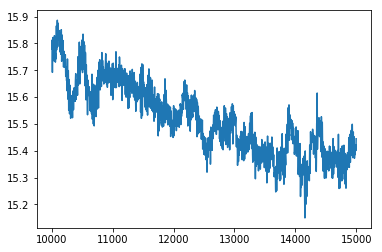

In [55]:
pd.Series(err_list).rolling(200).mean().iloc[10000:].plot()

In [57]:
samples_list = []
for i in tqdm(range(100)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df =data_samples[['days_left', 'oh_after', 'days_left_next', 'oh_after_next', 'action', 'rev_ser']].fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)




  0%|          | 0/100 [00:00<?, ?it/s]


  8%|▊         | 8/100 [00:00<00:01, 60.00it/s]


 14%|█▍        | 14/100 [00:00<00:01, 57.79it/s]


 18%|█▊        | 18/100 [00:00<00:01, 49.31it/s]


 22%|██▏       | 22/100 [00:00<00:01, 44.72it/s]


 28%|██▊       | 28/100 [00:00<00:01, 42.70it/s]


 32%|███▏      | 32/100 [00:00<00:01, 41.68it/s]


 37%|███▋      | 37/100 [00:00<00:01, 43.15it/s]


 42%|████▏     | 42/100 [00:00<00:01, 41.47it/s]


 46%|████▌     | 46/100 [00:01<00:01, 40.98it/s]


 53%|█████▎    | 53/100 [00:01<00:01, 45.78it/s]


 58%|█████▊    | 58/100 [00:01<00:00, 43.96it/s]


 65%|██████▌   | 65/100 [00:01<00:00, 48.71it/s]


 71%|███████   | 71/100 [00:01<00:00, 51.03it/s]


 77%|███████▋  | 77/100 [00:01<00:00, 52.77it/s]


 83%|████████▎ | 83/100 [00:01<00:00, 50.23it/s]


 90%|█████████ | 90/100 [00:01<00:00, 54.00it/s]


 97%|█████████▋| 97/100 [00:01<00:00, 56.42it/s]


100%|██████████| 100/100 [00:02<00:00, 49.32it/s]

In [58]:
pred_df = pd.DataFrame(model.predict(df[['oh_after', 'days_left']]), columns=  ['q_keep_pred', 'q_disc_pred'])
#pred_df = pd.DataFrame(model.predict(df[['oh_after', 'days_left']]), columns=  ['q_keep_pred'])

df['q_keep_pred'] = pred_df['q_keep_pred']
df['q_disc_pred'] = pred_df['q_disc_pred']

In [59]:
df[ ['days_left', 'oh_after','action','rev_ser' ,'Q_keep', 'Q_disc', 'q_keep_pred', 'q_disc_pred'] ]
#df[ ['days_left', 'oh_after','action','rev_ser' ,'Q_keep',  'q_keep_pred'] ]

,days_left,oh_after,action,rev_ser,Q_keep,Q_disc,q_keep_pred,q_disc_pred
0,11,758.0,0.00,41.00,562.7000,492.700,566.547791,493.753021
1,10,717.0,0.00,37.00,522.0500,466.050,524.177307,467.458649
2,9,680.0,0.00,36.00,484.0000,442.000,483.261078,443.844086
3,8,644.0,0.00,43.00,446.6000,418.600,442.708618,420.899658
4,7,601.0,0.00,72.80,404.6500,390.650,399.610657,393.265259
5,6,489.0,-0.35,66.95,331.8500,317.850,331.422363,319.402466
6,5,386.0,-0.35,80.60,264.9000,250.900,266.506653,251.569427
7,4,262.0,-0.35,50.70,198.3000,170.300,193.954742,169.666840
8,3,184.0,-0.35,52.65,141.5355,119.600,138.129761,118.583267
9,2,103.0,-0.35,64.35,80.9500,66.950,81.213928,65.489731




 22%|██▏       | 224/1000 [00:20<00:21, 36.53it/s]

### Честный Q-learning на Keras с использованием нейронных сетей

In [10]:
samples_list = []
for i in tqdm(range(1000)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df =data_samples[['days_left', 'oh_after', 'days_left_next', 'oh_after_next', 'action', 'rev_ser']].fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)

100%|██████████| 1000/1000 [00:18<00:00, 54.74it/s]


X_train = df[['oh_after', 'days_left']].values
labels_train = df[['Q_keep', 'Q_disc']].values

In [14]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import SGD, RMSprop,Adagrad

# define the architecture of the network
model = Sequential()
model.add(Dense(4, input_dim=2, init="uniform", activation="relu"))
#model.add(Dropout(0.2))
#model.add(Dense(128, activation="relu", kernel_initializer="uniform"))
#model.add(Dropout(0.5))
#model.add(Dense(128, activation="relu", kernel_initializer="uniform"))
#model.add(Dropout(0.5))
model.add(Dense(4, activation="relu", kernel_initializer="uniform"))
model.add(Dense(2))
model.compile(RMSprop(), 'MSE')



/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, input_dim=2, activation="relu", kernel_initializer="uniform")`
  


In [80]:
next_state_cols

['days_left_next', 'oh_after_next']

#%%timeit
pred_df = pd.DataFrame(model.predict(df[['oh_after', 'days_left']]), columns=  ['q_keep_pred', 'q_disc_pred'])

In [156]:
df[['pred_0','pred_m35']] = 0.

state_cols = ['oh_after','days_left']
next_state_cols = [col + '_next' for col in state_cols]


used_cols = ['days_left', 'oh_after', 'action', 'rev_ser', 'days_left_next', 'oh_after_next']
col_n2no =  {name:i for i, name in  enumerate(used_cols)}

X = df[used_cols].values

m35_order = 1
z_order = 0

state_cols_nos = [col_n2no[name] for name in state_cols]
next_state_cols_nos = [col_n2no[name] for name in next_state_cols]

state_cols_nos, next_state_cols_nos


([1, 0], [5, 4])

In [157]:
col_n2no

{'days_left': 0,
 'oh_after': 1,
 'action': 2,
 'rev_ser': 3,
 'days_left_next': 4,
 'oh_after_next': 5}

In [218]:
%%timeit


idx = np.random.randint(df.shape[0], size = 200)
X_curr = X[idx]

next_pred = model.predict(X_curr[:, next_state_cols_nos])
last_day_ind = np.where(X_curr[:, col_n2no['days_left_next']] ==0)

next_pred[last_day_ind] = 0.

m35_action_ind = np.where(X_curr[:, col_n2no['action']] == -0.35)
z_action_ind = np.where(X_curr[:, col_n2no['action']] ==0.)

next_pred[m35_action_ind, m35_order] += X_curr[m35_action_ind, col_n2no['rev_ser']]
next_pred[z_action_ind, z_order]   += X_curr[z_action_ind, col_n2no['rev_ser']]

err = model.train_on_batch(df_curr[['oh_after', 'days_left']].values, df_curr[['pred_0','pred_m35']].values)

8.94 ms ± 573 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Volumes/C/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [215]:
df_curr[['pred_0','pred_m35']]

,pred_0,pred_m35
1,50.595886,-0.510201
2,0.460323,60.808640
4,45.526691,-0.398502
4,0.456866,70.564217
7,0.172881,55.422657
8,0.172881,58.022659
5,33.490051,-0.339351
6,0.387947,66.775475
9,55.595665,-0.106270
7,0.194194,54.088253


In [216]:
next_pred

array([[ 5.05958862e+01, -5.10200620e-01],
       [ 4.60322678e-01,  6.08086395e+01],
       [ 4.55266914e+01, -3.98502290e-01],
       [ 4.56866145e-01,  7.05642166e+01],
       [ 1.72881410e-01,  5.54226570e+01],
       [ 1.72881410e-01,  5.80226593e+01],
       [ 3.34900513e+01, -3.39351356e-01],
       [ 3.87946844e-01,  6.67754745e+01],
       [ 5.55956650e+01, -1.06270015e-01],
       [ 1.94194436e-01,  5.40882530e+01],
       [ 5.24512291e+01, -2.76677758e-01],
       [ 5.26009789e+01, -5.18419981e-01],
       [ 3.13028336e-01,  6.49464188e+01],
       [ 4.35796089e+01, -4.83926892e-01],
       [ 3.55832481e+01, -4.89797950e-01],
       [ 4.83144462e-01,  5.42717972e+01],
       [ 4.14465904e+01, -2.69191116e-01],
       [ 6.79180298e+01, -6.16508573e-02],
       [ 3.15774288e+01, -4.80404377e-01],
       [ 5.00781536e-01,  5.42433281e+01],
       [ 3.66399467e-01,  6.48602600e+01],
       [ 4.03798523e+01, -1.61456853e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 6.

In [207]:
X_curr[:, col_n2no['action']]

array([ 0.  , -0.35,  0.  , -0.35, -0.35, -0.35,  0.  , -0.35,  0.  ,
       -0.35,  0.  ,  0.  , -0.35,  0.  ,  0.  , -0.35,  0.  ,  0.  ,
        0.  , -0.35, -0.35,  0.  , -0.35,  0.  ,  0.  , -0.35,  0.  ,
       -0.35, -0.35,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
       -0.35,  0.  ,  0.  ,  0.  , -0.35, -0.35, -0.35,  0.  ,  0.  ,
       -0.35,  0.  ,  0.  , -0.35,  0.  , -0.35,  0.  , -0.35, -0.35,
        0.  , -0.35, -0.35, -0.35, -0.35, -0.35, -0.35, -0.35,  0.  ,
        0.  , -0.35,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.35,  0.  ,
        0.  ,  0.  ,  0.  , -0.35, -0.35,  0.  , -0.35, -0.35, -0.35,
       -0.35, -0.35, -0.35, -0.35, -0.35, -0.35, -0.35, -0.35,  0.  ,
        0.  , -0.35,  0.  , -0.35,  0.  , -0.35, -0.35, -0.35,  0.  ,
        0.  ,  0.  ,  0.  , -0.35,  0.  ,  0.  , -0.35,  0.  ,  0.  ,
       -0.35,  0.  ,  0.  , -0.35,  0.  , -0.35,  0.  , -0.35,  0.  ,
        0.  , -0.35,  0.  , -0.35,  0.  , -0.35,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,

In [203]:
df_curr[['pred_0','pred_m35']]

,pred_0,pred_m35
1,0.595886,-0.510201
2,0.460323,-0.291360
4,0.526693,-0.398502
4,0.456866,-0.285780
7,0.172881,0.172658
8,0.172881,0.172658
5,0.490051,-0.339351
6,0.387947,-0.174523
9,0.345666,-0.106270
7,0.194194,0.138252


In [204]:
next_pred

array([[ 0.59588593, -0.5102006 ],
       [ 0.46032268, -0.2913601 ],
       [ 0.5266931 , -0.3985023 ],
       [ 0.45686615, -0.28578025],
       [ 0.17288141,  0.1726579 ],
       [ 0.17288141,  0.1726579 ],
       [ 0.4900514 , -0.33935136],
       [ 0.38794684, -0.17452344],
       [ 0.34566647, -0.10627002],
       [ 0.19419444,  0.13825217],
       [ 0.4512275 , -0.27667776],
       [ 0.6009775 , -0.51842   ],
       [ 0.31302834, -0.05358206],
       [ 0.57961035, -0.4839269 ],
       [ 0.58324724, -0.48979795],
       [ 0.48314446, -0.32820153],
       [ 0.44658983, -0.26919112],
       [ 0.31802666, -0.06165086],
       [ 0.5774283 , -0.48040438],
       [ 0.50078154, -0.35667312],
       [ 0.36639947, -0.1397394 ],
       [ 0.3798526 , -0.16145685],
       [ 0.        ,  0.        ],
       [ 0.3391202 , -0.09570232],
       [ 0.5150553 , -0.37971532],
       [ 0.17288141,  0.1726579 ],
       [ 0.5458781 , -0.42947274],
       [ 0.3463068 , -0.10730368],
       [ 0.36730713,

### Правильная, но медленная версия

In [217]:
err_list = []
for i in tqdm(range(100)):
    idx = np.random.randint(df.shape[0], size = 200)
    df_curr = df.iloc[idx]

    #model.predict(X)
    df_curr['pred_0'] = model.predict(df_curr[['oh_after_next','days_left_next']])[:,0]
    df_curr['pred_m35'] = model.predict(df_curr[['oh_after_next','days_left_next']])[:,1]

    df_curr.loc[df_curr.days_left == 0, ['pred_0','pred_m35']] = 0.



    df_curr.loc[df_curr.action == -.35, 'pred_m35']  += df_curr.loc[df_curr.action == -.35, 'rev_ser']
    df_curr.loc[df_curr.action ==   0., 'pred_0']    += df_curr.loc[df_curr.action ==   0., 'rev_ser']

    
    err = model.train_on_batch(df_curr[['oh_after', 'days_left']].values, df_curr[['pred_0','pred_m35']].values)
    err_list.append(err)
    if not i%20:
        print(err)








  0%|          | 0/100 [00:00<?, ?it/s]/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Volumes/C/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

1260.7205








  2%|▏         | 2/100 [00:02<02:12,  1.35s/it]





  3%|▎         | 3/100 [00:03<02:09,  1.34s/it]





  4%|▍         | 4/100 [00:05<02:08,  1.34s/it]





  5%|▌         | 5/100 [00:06<02:06,  1.33s/it]

KeyboardInterrupt: 

### Это же, но быстрее

In [226]:
err_list = []
q_0_hist = []
for i in tqdm(range(150000), mininterval=10):
    idx = np.random.randint(df.shape[0], size = 500)
    X_curr = X[idx]

    next_pred = model.predict(X_curr[:, next_state_cols_nos])
    last_day_ind = np.where(X_curr[:, col_n2no['days_left_next']] ==0)

    next_pred[last_day_ind] = 0.

    m35_action_ind = np.where(X_curr[:, col_n2no['action']] == -0.35)
    z_action_ind = np.where(X_curr[:, col_n2no['action']] ==0.)

    next_pred[m35_action_ind, m35_order] += X_curr[m35_action_ind, col_n2no['rev_ser']]
    next_pred[z_action_ind, z_order]   += X_curr[z_action_ind, col_n2no['rev_ser']]

    err = model.train_on_batch(X_curr[:,state_cols_nos], next_pred)
    err_list.append(err)
    if not i%500:
        mean_q_0 = next_pred[np.where(X_curr[:, col_n2no['days_left_next']] ==10)].mean(0)
        q_0_hist.append(mean_q_0)
        print(err)









  0%|          | 0/150000 [00:00<?, ?it/s]

1354.6987
1324.5228










  1%|          | 869/150000 [00:10<28:37, 86.85it/s]

967.90186
1477.3752










  1%|          | 1749/150000 [00:20<28:20, 87.17it/s]

1191.3757
2172.5415










  2%|▏         | 2632/150000 [00:30<28:04, 87.51it/s]

1979.8628










  2%|▏         | 2632/150000 [00:40<28:04, 87.51it/s]







  2%|▏         | 3426/150000 [00:40<29:34, 82.60it/s]

1358.1594
918.0767










  3%|▎         | 4267/150000 [00:50<29:15, 83.03it/s]

1322.7762
1856.4417










  3%|▎         | 5108/150000 [01:01<29:43, 81.24it/s]

1059.7275










  4%|▍         | 5882/150000 [01:13<31:42, 75.76it/s]

1146.4305
1432.9883










  4%|▍         | 6537/150000 [01:30<40:08, 59.56it/s]

1691.6749










  5%|▍         | 7042/150000 [01:40<42:11, 56.48it/s]







  5%|▍         | 7042/150000 [01:50<42:11, 56.48it/s]







  5%|▍         | 7392/150000 [01:50<51:36, 46.05it/s]

1490.7349










  5%|▌         | 7836/150000 [02:00<52:03, 45.52it/s]

1257.2762










  6%|▌         | 8280/150000 [02:11<52:20, 45.13it/s]

1765.6777










  6%|▌         | 8727/150000 [02:21<52:21, 44.98it/s]

1292.8848










  6%|▌         | 9174/150000 [02:31<52:25, 44.77it/s]

1384.2031










  6%|▋         | 9618/150000 [02:50<1:06:51, 35.00it/s]







  7%|▋         | 9854/150000 [03:00<1:16:40, 30.46it/s]

1116.8945










  7%|▋         | 9854/150000 [03:10<1:16:40, 30.46it/s]







  7%|▋         | 10052/150000 [03:11<1:31:23, 25.52it/s]







  7%|▋         | 10238/150000 [03:24<1:52:34, 20.69it/s]

1128.9373










  7%|▋         | 10677/150000 [03:34<1:34:27, 24.58it/s]

1195.3147










  7%|▋         | 11116/150000 [03:47<1:26:29, 26.76it/s]

1717.215










  8%|▊         | 11602/150000 [03:57<1:14:35, 30.93it/s]

1047.3895










  8%|▊         | 12150/150000 [04:07<1:04:35, 35.57it/s]

991.40845










  9%|▊         | 12987/150000 [04:17<53:07, 42.98it/s]  

1074.234
1059.8596










  9%|▉         | 13839/150000 [04:27<44:56, 50.49it/s]

1247.9978
1172.3877










 10%|▉         | 14720/150000 [04:37<38:56, 57.90it/s]

1457.9034
1100.8472










 10%|█         | 15601/150000 [04:47<34:51, 64.26it/s]

1207.3601










 11%|█         | 16466/150000 [04:57<32:08, 69.26it/s]

1252.4188
1340.1194










 12%|█▏        | 17330/150000 [05:07<30:01, 73.64it/s]

1115.2327
763.9541










 12%|█▏        | 18215/150000 [05:17<28:19, 77.54it/s]

1506.4738
1141.1747










 13%|█▎        | 19100/150000 [05:27<27:09, 80.33it/s]

868.422










 13%|█▎        | 19977/150000 [05:37<26:19, 82.31it/s]

1265.8186
2207.7805










 14%|█▍        | 20851/150000 [05:48<26:41, 80.65it/s]

947.19446
1955.387










 14%|█▍        | 21646/150000 [05:58<26:38, 80.28it/s]

1464.2336
1236.2922










 15%|█▌        | 22528/150000 [06:08<25:45, 82.49it/s]

1402.8063










 16%|█▌        | 23414/150000 [06:18<25:03, 84.22it/s]

1371.3473
886.4914










 16%|█▌        | 24300/150000 [06:30<25:17, 82.83it/s]

913.6553










 16%|█▌        | 24300/150000 [06:41<25:17, 82.83it/s]







 17%|█▋        | 24930/150000 [06:41<28:38, 72.80it/s]

1157.2268










 17%|█▋        | 25498/150000 [06:52<31:50, 65.18it/s]

1341.4062
1161.889










 17%|█▋        | 26088/150000 [07:02<32:41, 63.17it/s]

1280.224










 18%|█▊        | 26678/150000 [07:13<34:57, 58.80it/s]

1602.8685










 18%|█▊        | 27339/150000 [07:23<33:37, 60.80it/s]

1431.2717










 19%|█▊        | 28012/150000 [07:33<32:29, 62.59it/s]

1559.1818
1276.2291










 19%|█▉        | 28684/150000 [07:43<31:52, 63.44it/s]

1509.56










 20%|█▉        | 29404/150000 [07:54<30:33, 65.77it/s]

1310.079
838.6366










 20%|██        | 30124/150000 [08:05<30:56, 64.56it/s]

1078.2087










 21%|██        | 30832/150000 [08:15<29:57, 66.30it/s]

1123.1558
1064.4022










 21%|██        | 31540/150000 [08:26<29:39, 66.58it/s]

1230.6987










 21%|██▏       | 32242/150000 [08:36<29:01, 67.61it/s]

1364.1534










 22%|██▏       | 32956/150000 [08:46<28:23, 68.69it/s]

1560.7695
1513.8884










 22%|██▏       | 33670/150000 [08:56<28:12, 68.73it/s]

1215.8175










 23%|██▎       | 34359/150000 [09:06<28:04, 68.63it/s]

1227.1316
1262.5487










 23%|██▎       | 35070/150000 [09:16<27:38, 69.32it/s]

1526.357










 24%|██▍       | 35782/150000 [09:26<27:14, 69.87it/s]

1596.491










 24%|██▍       | 36494/150000 [09:37<27:29, 68.81it/s]

902.9264
1320.912










 25%|██▍       | 37159/150000 [09:47<27:42, 67.88it/s]

1621.741










 25%|██▌       | 37857/150000 [09:57<27:18, 68.43it/s]

1207.6638
1451.5942










 26%|██▌       | 38558/150000 [10:07<26:57, 68.91it/s]

1542.337










 26%|██▌       | 39278/150000 [10:17<26:26, 69.80it/s]

994.4752










 27%|██▋       | 39998/150000 [10:29<27:53, 65.74it/s]

1885.5017
1590.9214










 27%|██▋       | 40629/150000 [10:39<28:04, 64.92it/s]

1134.385










 28%|██▊       | 41260/150000 [10:50<28:27, 63.67it/s]

1204.5364










 28%|██▊       | 41870/150000 [11:00<28:48, 62.57it/s]

1203.1038










 28%|██▊       | 41870/150000 [11:11<28:48, 62.57it/s]







 28%|██▊       | 42165/150000 [11:11<39:44, 45.22it/s]







 28%|██▊       | 42440/150000 [11:23<51:54, 34.53it/s]

1651.6301










 28%|██▊       | 42706/150000 [11:33<56:25, 31.69it/s]

1310.2997










 29%|██▊       | 43044/150000 [11:43<55:15, 32.26it/s]

1193.263










 29%|██▉       | 43623/150000 [11:53<47:39, 37.20it/s]

1499.6636










 30%|██▉       | 44296/150000 [12:03<41:00, 42.96it/s]

1602.658










 30%|██▉       | 44985/150000 [12:13<36:08, 48.42it/s]

1350.1561
1473.4335










 31%|███       | 45765/150000 [12:23<31:47, 54.63it/s]

1251.0051
1173.9757










 31%|███       | 46566/150000 [12:33<28:32, 60.39it/s]

1565.3262










 32%|███▏      | 47370/150000 [12:43<26:12, 65.26it/s]

937.232
1566.4885










 32%|███▏      | 48174/150000 [12:59<28:22, 59.82it/s]

1318.1771










 32%|███▏      | 48675/150000 [13:10<30:19, 55.68it/s]

1835.1279










 33%|███▎      | 49411/150000 [13:20<27:54, 60.06it/s]

962.209










 33%|███▎      | 49411/150000 [13:31<27:54, 60.06it/s]







 33%|███▎      | 49952/150000 [13:31<29:41, 56.15it/s]

1790.9211
1171.9338










 34%|███▎      | 50561/150000 [13:41<28:50, 57.48it/s]

1654.3771










 34%|███▍      | 51239/150000 [13:51<27:20, 60.21it/s]

1368.4038










 35%|███▍      | 51917/150000 [14:01<26:19, 62.09it/s]

1159.8026
1793.6044










 35%|███▌      | 52587/150000 [14:11<25:34, 63.49it/s]

1369.6235










 36%|███▌      | 53329/150000 [14:21<24:16, 66.36it/s]

1308.0217
1291.9342










 36%|███▌      | 54071/150000 [14:31<23:31, 67.94it/s]

1335.9432










 37%|███▋      | 54791/150000 [14:42<23:46, 66.74it/s]

1113.2167










 37%|███▋      | 55459/150000 [14:52<23:36, 66.73it/s]

1481.946
1761.7651










 37%|███▋      | 56127/150000 [15:05<25:31, 61.31it/s]

1626.3934










 37%|███▋      | 56127/150000 [15:21<25:31, 61.31it/s]







 38%|███▊      | 56627/150000 [15:21<32:12, 48.31it/s]







 38%|███▊      | 56951/150000 [15:32<37:53, 40.92it/s]

1124.298
1545.9364










 38%|███▊      | 57613/150000 [15:42<33:19, 46.21it/s]

1255.346










 39%|███▉      | 58275/150000 [15:52<30:42, 49.78it/s]

1124.6439










 39%|███▉      | 58883/150000 [16:04<30:00, 50.61it/s]

2081.002










 40%|███▉      | 59450/150000 [16:14<28:52, 52.28it/s]

1620.4067










 40%|███▉      | 59450/150000 [16:31<28:52, 52.28it/s]







 40%|███▉      | 59858/150000 [16:31<38:48, 38.72it/s]

1219.0145










 40%|████      | 60169/150000 [16:41<41:31, 36.05it/s]

1489.126










 40%|████      | 60630/150000 [16:51<38:37, 38.57it/s]

1213.9034










 41%|████      | 61268/150000 [17:01<33:47, 43.76it/s]

1241.1085
1247.9762










 41%|████▏     | 62069/150000 [17:11<28:56, 50.65it/s]

1233.354










 42%|████▏     | 62870/150000 [17:22<25:57, 55.95it/s]

1729.3994
1557.856










 42%|████▏     | 63611/150000 [17:33<24:17, 59.27it/s]

1637.1672










 43%|████▎     | 64300/150000 [17:44<23:58, 59.58it/s]

1266.1122










 43%|████▎     | 64904/150000 [17:56<25:19, 56.01it/s]

1077.695
1686.8728










 44%|████▍     | 65632/150000 [18:06<23:22, 60.17it/s]

1184.1257










 44%|████▍     | 66360/150000 [18:17<22:21, 62.34it/s]

918.9383
1436.2948










 45%|████▍     | 67041/150000 [18:28<22:10, 62.37it/s]

1101.0878










 45%|████▌     | 67835/150000 [18:38<20:32, 66.64it/s]

1566.216
1045.7769










 46%|████▌     | 68629/150000 [18:50<20:23, 66.53it/s]

1601.366










 46%|████▌     | 69361/150000 [19:00<19:39, 68.38it/s]

1089.6108
1592.0804










 47%|████▋     | 70146/150000 [19:10<18:42, 71.12it/s]

1319.8096










 47%|████▋     | 70146/150000 [19:21<18:42, 71.12it/s]







 47%|████▋     | 70896/150000 [19:21<18:45, 70.27it/s]

1526.2699
1594.2185










 48%|████▊     | 71677/150000 [19:31<18:01, 72.44it/s]

1754.4384










 48%|████▊     | 72458/150000 [19:42<17:53, 72.24it/s]

1175.5348
1209.8855










 49%|████▉     | 73176/150000 [19:52<18:05, 70.74it/s]

1005.24713










 49%|████▉     | 73902/150000 [20:02<17:47, 71.28it/s]

1493.0415
1642.099










 50%|████▉     | 74628/150000 [20:15<19:04, 65.87it/s]

1292.2742










 50%|█████     | 75275/150000 [20:25<19:00, 65.49it/s]

1487.2156










 51%|█████     | 76001/150000 [20:35<18:17, 67.45it/s]

1287.6903
1260.3414










 51%|█████     | 76727/150000 [20:46<17:57, 68.00it/s]

1229.1422










 52%|█████▏    | 77421/150000 [20:58<18:53, 64.03it/s]

1428.0417
1843.5277










 52%|█████▏    | 78150/150000 [21:08<18:01, 66.44it/s]

1392.1685










 53%|█████▎    | 78879/150000 [21:19<17:55, 66.12it/s]

1413.8419
1953.9249










 53%|█████▎    | 79589/150000 [21:29<17:23, 67.51it/s]

1790.6041










 54%|█████▎    | 80299/150000 [21:40<17:03, 68.11it/s]

1426.6992










 54%|█████▍    | 80995/150000 [21:50<17:00, 67.59it/s]

1472.1293
1378.4492










 54%|█████▍    | 81731/150000 [22:00<16:25, 69.26it/s]

1110.5167










 55%|█████▍    | 82466/150000 [22:11<16:13, 69.35it/s]

1335.3094
1408.2948










 55%|█████▍    | 82466/150000 [22:21<16:13, 69.35it/s]







 55%|█████▌    | 83022/150000 [22:21<17:29, 63.82it/s]

1216.5876










 56%|█████▌    | 83591/150000 [22:31<17:59, 61.51it/s]

1398.244










 56%|█████▌    | 84200/150000 [22:41<17:52, 61.33it/s]

1137.2169










 57%|█████▋    | 84809/150000 [22:52<18:15, 59.53it/s]

1139.5518










 57%|█████▋    | 85367/150000 [23:06<21:00, 51.28it/s]

1835.5302
1594.4833










 57%|█████▋    | 86072/150000 [23:16<19:04, 55.83it/s]

1827.1149










 58%|█████▊    | 86849/150000 [23:26<17:15, 60.98it/s]

1985.8848
1708.5908










 58%|█████▊    | 87626/150000 [23:39<16:54, 61.48it/s]

1891.1304










 59%|█████▉    | 88409/150000 [23:49<15:37, 65.71it/s]

1008.51526
1247.6288










 59%|█████▉    | 89192/150000 [23:59<14:53, 68.05it/s]

1417.9304










 59%|█████▉    | 89192/150000 [24:11<14:53, 68.05it/s]







 60%|█████▉    | 89920/150000 [24:11<15:08, 66.14it/s]

1250.6322
1121.4158










 60%|██████    | 90541/150000 [24:23<16:20, 60.65it/s]

1167.7567










 61%|██████    | 91138/150000 [24:33<16:15, 60.33it/s]

1410.2882










 61%|██████    | 91735/150000 [24:44<16:40, 58.26it/s]

1374.5568










 62%|██████▏   | 92292/150000 [24:54<16:44, 57.44it/s]

1468.5853










 62%|██████▏   | 92848/150000 [25:05<17:06, 55.65it/s]

1685.662










 62%|██████▏   | 93439/150000 [25:15<16:39, 56.60it/s]

1319.2042










 62%|██████▏   | 93439/150000 [25:31<16:39, 56.60it/s]







 63%|██████▎   | 94004/150000 [25:31<19:28, 47.94it/s]

3451.008










 63%|██████▎   | 94457/150000 [25:41<19:39, 47.07it/s]

1360.6367










 63%|██████▎   | 94930/150000 [25:51<19:28, 47.11it/s]

1712.877










 64%|██████▎   | 95403/150000 [26:09<23:57, 37.97it/s]

1716.0284










 64%|██████▎   | 95403/150000 [26:21<23:57, 37.97it/s]







 64%|██████▍   | 95659/150000 [26:21<29:17, 30.92it/s]

1082.196










 64%|██████▍   | 96034/150000 [26:31<27:34, 32.63it/s]

2192.1016










 65%|██████▍   | 96814/150000 [26:41<22:25, 39.51it/s]

1318.0027
1050.6047










 65%|██████▌   | 97635/150000 [26:51<18:38, 46.80it/s]

1725.5099










 66%|██████▌   | 98456/150000 [27:03<16:28, 52.14it/s]

2448.9983
1106.9135










 66%|██████▌   | 99167/150000 [27:17<16:27, 51.47it/s]

1159.6539










 67%|██████▋   | 99929/150000 [27:27<14:38, 57.02it/s]

1278.8557
1610.2322










 67%|██████▋   | 99929/150000 [27:41<14:38, 57.02it/s]







 67%|██████▋   | 100523/150000 [27:41<16:02, 51.42it/s]







 67%|██████▋   | 100523/150000 [28:01<16:02, 51.42it/s]







 67%|██████▋   | 100920/150000 [28:01<23:31, 34.77it/s]

1587.5554










 67%|██████▋   | 101119/150000 [28:12<30:07, 27.04it/s]







 68%|██████▊   | 101298/150000 [28:23<36:13, 22.41it/s]







 68%|██████▊   | 101461/150000 [28:34<40:11, 20.13it/s]

1397.272










 68%|██████▊   | 101946/150000 [28:44<32:48, 24.41it/s]

1869.2893
1110.8602










 68%|██████▊   | 102679/150000 [28:54<25:50, 30.51it/s]

1237.216










 69%|██████▉   | 103412/150000 [29:07<22:10, 35.02it/s]

1014.56915










 69%|██████▉   | 103412/150000 [29:21<22:10, 35.02it/s]







 69%|██████▉   | 103924/150000 [29:21<21:41, 35.40it/s]

1619.9437










 70%|██████▉   | 104288/150000 [29:32<21:36, 35.26it/s]

1398.9628










 70%|██████▉   | 104762/150000 [29:42<19:44, 38.19it/s]

1386.4908










 70%|███████   | 105374/150000 [29:52<17:16, 43.04it/s]

1528.1915
1259.5665










 71%|███████   | 106166/150000 [30:02<14:39, 49.87it/s]

1645.2317










 71%|███████▏  | 106958/150000 [30:12<12:56, 55.46it/s]

1009.6399
909.3499










 72%|███████▏  | 107710/150000 [30:27<12:54, 54.63it/s]

1023.26843










 72%|███████▏  | 108238/150000 [30:38<13:18, 52.29it/s]

1763.5248
1474.7192










 73%|███████▎  | 109056/150000 [30:48<11:38, 58.62it/s]

1846.681










 73%|███████▎  | 109874/150000 [30:58<10:28, 63.86it/s]

1965.6748
1677.1727










 74%|███████▍  | 110748/150000 [31:08<09:25, 69.47it/s]

1395.457
1820.8931










 74%|███████▍  | 111622/150000 [31:19<08:56, 71.58it/s]

1568.7817










 75%|███████▍  | 112458/150000 [31:29<08:21, 74.79it/s]

1273.9137
1163.047










 76%|███████▌  | 113294/150000 [31:40<08:04, 75.76it/s]

1163.0477
1599.6165










 76%|███████▌  | 114076/150000 [31:50<07:50, 76.39it/s]

1386.6362










 77%|███████▋  | 114856/150000 [32:01<07:46, 75.40it/s]

1507.8735
1138.5492










 77%|███████▋  | 115588/150000 [32:11<07:42, 74.46it/s]

1248.122










 77%|███████▋  | 115588/150000 [32:21<07:42, 74.46it/s]







 77%|███████▋  | 116223/150000 [32:21<08:05, 69.55it/s]

1296.976










 78%|███████▊  | 116826/150000 [32:36<09:33, 57.87it/s]

1538.1935










 78%|███████▊  | 117242/150000 [32:47<10:55, 49.96it/s]

1471.0415










 79%|███████▊  | 117801/150000 [32:57<10:24, 51.60it/s]

1401.8234
1331.2661










 79%|███████▉  | 118536/150000 [33:07<09:15, 56.65it/s]

1601.495










 80%|███████▉  | 119271/150000 [33:19<08:53, 57.60it/s]

1382.8457










 80%|███████▉  | 119871/150000 [33:30<08:48, 56.99it/s]

1206.7437










 80%|████████  | 120476/150000 [33:40<08:29, 57.99it/s]

1457.6486
1407.5348










 80%|████████  | 120476/150000 [33:51<08:29, 57.99it/s]







 81%|████████  | 121047/150000 [33:51<08:44, 55.21it/s]

1317.701










 81%|████████  | 121547/150000 [34:01<08:51, 53.53it/s]

1208.314










 81%|████████▏ | 122080/150000 [34:11<08:42, 53.44it/s]

1364.987










 82%|████████▏ | 122613/150000 [34:21<08:34, 53.27it/s]

1681.8271










 82%|████████▏ | 123265/150000 [34:31<07:54, 56.34it/s]

1304.2019
1005.69806










 83%|████████▎ | 124064/150000 [34:41<06:59, 61.79it/s]

1460.7837










 83%|████████▎ | 124862/150000 [34:53<06:30, 64.40it/s]

949.5565
1311.7865










 83%|████████▎ | 124862/150000 [35:11<06:30, 64.40it/s]







 84%|████████▎ | 125570/150000 [35:11<07:39, 53.18it/s]







 84%|████████▍ | 125949/150000 [35:23<09:05, 44.08it/s]

1103.9928










 84%|████████▍ | 126416/150000 [35:33<08:46, 44.78it/s]

1424.7383










 85%|████████▍ | 126951/150000 [35:43<08:09, 47.05it/s]

1933.8385










 85%|████████▍ | 127485/150000 [35:55<08:04, 46.46it/s]

1554.7032










 85%|████████▌ | 127991/150000 [36:05<07:42, 47.62it/s]

1066.5587
876.79065










 86%|████████▌ | 128533/150000 [36:15<07:14, 49.41it/s]

1456.9806










 86%|████████▌ | 129186/150000 [36:25<06:30, 53.30it/s]

1494.331










 87%|████████▋ | 129839/150000 [36:36<06:00, 55.90it/s]

1611.5375
1869.8833










 87%|████████▋ | 130704/150000 [36:46<05:08, 62.53it/s]

1236.377
1418.2657










 88%|████████▊ | 131569/150000 [36:58<04:47, 64.02it/s]

1098.5554










 88%|████████▊ | 132247/150000 [37:10<04:46, 61.93it/s]

1385.2435
1436.6855










 89%|████████▊ | 133062/150000 [37:20<04:13, 66.72it/s]

1884.8345










 89%|████████▉ | 133918/150000 [37:30<03:45, 71.44it/s]

1333.625
1713.5548










 90%|████████▉ | 134774/150000 [37:40<03:23, 74.99it/s]

1566.847
1657.6658










 90%|█████████ | 135624/150000 [37:50<03:04, 77.72it/s]

1561.0463










 91%|█████████ | 136496/150000 [38:00<02:48, 80.33it/s]

1597.9052
867.7581










 91%|█████████ | 136496/150000 [38:11<02:48, 80.33it/s]







 91%|█████████▏| 137207/150000 [38:11<02:51, 74.67it/s]

1276.0343










 92%|█████████▏| 137849/150000 [38:23<03:02, 66.58it/s]

1244.6576










 92%|█████████▏| 138490/150000 [38:33<02:54, 65.80it/s]

779.8075
1160.546










 93%|█████████▎| 139253/150000 [38:43<02:36, 68.63it/s]

1243.6534
1098.5249










 93%|█████████▎| 140121/150000 [38:53<02:14, 73.19it/s]

952.76465










 94%|█████████▍| 140988/150000 [39:05<02:01, 74.41it/s]

1176.4688
1015.4059










 95%|█████████▍| 141849/150000 [39:15<01:45, 77.57it/s]

1022.2018
1744.5125










 95%|█████████▌| 142719/150000 [39:25<01:30, 80.16it/s]

1470.4739
1335.3846










 96%|█████████▌| 143589/150000 [39:35<01:18, 81.83it/s]

1263.664










 96%|█████████▋| 144462/150000 [39:45<01:06, 83.36it/s]

1605.7487
1494.1768










 97%|█████████▋| 145334/150000 [39:55<00:55, 84.20it/s]

1405.6787
1781.926










 97%|█████████▋| 146198/150000 [40:05<00:44, 84.84it/s]

1545.237
1666.4735










 98%|█████████▊| 147065/150000 [40:15<00:34, 85.37it/s]

1514.2462










 99%|█████████▊| 147943/150000 [40:25<00:23, 86.06it/s]

1332.7476
1790.2457










 99%|█████████▉| 148821/150000 [40:35<00:13, 86.35it/s]

2910.838
1399.5782










100%|█████████▉| 149692/150000 [40:47<00:03, 80.99it/s]







100%|██████████| 150000/150000 [40:51<00:00, 61.19it/s]

In [227]:
np.array(q_0_hist)

array([[268.2411 , 228.60457],
       [275.9896 , 220.16052],
       [234.5836 , 267.27673],
       [247.80829, 252.0726 ],
       [261.50177, 238.85991],
       [268.88284, 222.3203 ],
       [233.04756, 263.28696],
       [285.18338, 208.01631],
       [257.08295, 243.83136],
       [223.7363 , 278.5923 ],
       [279.87576, 215.85844],
       [310.12753, 180.46797],
       [197.26541, 312.94977],
       [246.42593, 253.23882],
       [248.72592, 252.85684],
       [238.51358, 266.89096],
       [293.09244, 199.03815],
       [326.7146 , 156.08542],
       [223.2717 , 283.4899 ],
       [288.1924 , 200.34341],
       [255.88564, 242.03621],
       [228.42764, 273.8501 ],
       [233.70642, 267.46252],
       [229.35077, 270.6766 ],
       [209.8825 , 303.0286 ],
       [215.07141, 293.76376],
       [220.62411, 284.84393],
       [241.26831, 260.834  ],
       [288.11325, 202.38821],
       [266.05817, 234.02753],
       [266.80438, 234.93521],
       [251.21558, 253.71742],
       [

In [ ]:
idx = np.random.randint(df.shape[0], size = 500)
df_curr = df.iloc[idx]


In [73]:
df_curr['pred_m35'] = 0


/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [76]:
df

,days_left,oh_after,days_left_next,oh_after_next,action,rev_ser,dumm_0,dumm_m35,V,Q_keep,Q_disc
0,11,756.0,10.0,707.0,0.00,49.00,0.0,-0.35,561.4000,561.4000,491.4000
1,10,707.0,9.0,657.0,0.00,50.00,0.0,-0.35,515.5500,515.5500,459.5500
2,9,657.0,8.0,615.0,0.00,42.00,0.0,-0.35,469.0500,469.0500,427.0500
3,8,615.0,7.0,569.0,0.00,46.00,0.0,-0.35,427.7500,427.7500,399.7500
4,7,569.0,6.0,472.0,0.00,63.05,0.0,-0.35,387.6775,387.6775,369.8500
5,6,472.0,5.0,357.0,-0.35,74.75,0.0,-0.35,326.1420,326.1420,306.8000
6,5,357.0,4.0,253.0,-0.35,67.60,0.0,-0.35,260.0500,260.0500,232.0500
7,4,253.0,3.0,166.0,-0.35,56.55,0.0,-0.35,192.4500,192.4500,164.4500
8,3,166.0,2.0,79.0,-0.35,56.55,0.0,-0.35,135.9000,135.9000,107.9000
9,2,79.0,1.0,0.0,-0.35,51.35,0.0,-0.35,79.0000,79.0000,51.3500


# Тут разная чушь, не имеющая значения

In [ ]:
import os
from random import sample as rsample

import numpy as np

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten
from keras.optimizers import SGD, RMSprop

from matplotlib import pyplot as plt


GRID_SIZE = 10


nb_epochs = 1000
batch_size = 128
epsilon = .8
gamma = .8

# Recipe of deep reinforcement learning model
model = Sequential()
model.add(Convolution2D(16, nb_row=3, nb_col=3, input_shape=(1, GRID_SIZE, GRID_SIZE), activation='relu'))
model.add(Convolution2D(16, nb_row=3, nb_col=3, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(3))
model.compile(RMSprop(), 'MSE')

exp_replay = experience_replay(batch_size)
exp_replay.next()  # Start experience-replay coroutine

for i in xrange(nb_epochs):
    ep = episode()
    S, won = ep.next()  # Start coroutine of single entire episode
    loss = 0.
    try:
        while True:
            action = np.random.randint(-1, 2) 
            if np.random.random() > epsilon:
                # Get the index of the maximum q-value of the model.
                # Subtract one because actions are either -1, 0, or 1
                action = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1

            S_prime, won = ep.send(action)
            experience = (S, action, won, S_prime)
            S = S_prime
            
            batch = exp_replay.send(experience)
            if batch:
                inputs = []
                targets = []
                for s, a, r, s_prime in batch:
                    # The targets of unchosen actions are the q-values of the model,
                    # so that the corresponding errors are 0. The targets of chosen actions
                    # are either the rewards, in case a terminal state has been reached, 
                    # or future discounted q-values, in case episodes are still running.
                    t = model.predict(s[np.newaxis]).flatten()
                    t[a + 1] = r
                    if not r:
                        t[a + 1] = r + gamma * model.predict(s_prime[np.newaxis]).max(axis=-1)
                    targets.append(t)
                    inputs.append(s)
                
                loss += model.train_on_batch(np.array(inputs), np.array(targets))[0]

    except StopIteration:
        pass
    
    if (i + 1) % 100 == 0:
        print 'Epoch %i, loss: %.6f' % (i + 1, loss)


def save_img():
    if 'images' not in os.listdir('.'):
        os.mkdir('images')
    frame = 0
    while True:
        screen = (yield)
        plt.imshow(screen[0], interpolation='none')
        plt.savefig('images/%03i.png' % frame)
        frame += 1
    
img_saver = save_img()
img_saver.next()

for _ in xrange(10):
    g = episode()
    S, _ = g.next()
    img_saver.send(S)
    try:
        while True:
            act = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1
            S, _ = g.send(act)
            img_saver.send(S)

    except StopIteration:
        pass

img_saver.close()

In [ ]:
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [ ]:
init = tf.initialize_all_variables()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print "Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%"